## What are the Limitations of Autoencoders ?

1. **No generative capability**  
   - Autoencoders learn to compress and reconstruct data, but they do not model a probability distribution.
   - Sampling from the latent space often results in meaningless outputs.

2. **Unstructured / discontinuous latent space**  
   - The latent space learned by an AE may be irregular, fragmented, or sparse.
   - Interpolation between latent points may not produce meaningful data.

3. **Overfitting and memorization**  
   - AEs can easily memorize the input (especially when overparameterized), reducing their generalization ability.
   - Without regularization, they may just learn the identity function.

4. **No probabilistic interpretation**  
   - Encodings and decodings are deterministic.
   - There’s no representation of uncertainty or variability in the data.

## Motivation for **Variational Autoencoders** (VAEs)

**Variational Autoencoders**  (VAEs) were designed to address the above limitations and enable true **generative modeling**.

### Key Advantages of VAEs

1. **Latent space regularization**  
   - VAEs enforce the latent space to follow a known prior distribution (typically a standard normal).
   - A KL divergence term penalizes deviation from this prior.

2. **Uncertainty-aware encoding**  
   - VAEs encode inputs into a distribution $q(z|x) \sim \mathcal{N}(\mu, \sigma^2)$ instead of a fixed point.
   - This allows uncertainty modeling and robust sampling.

3. **Generative modeling capability**  
   - After training, we can sample from $ z \sim \mathcal{N}(0, I)$ and decode to generate new data.
   - The decoder serves as a generative model $p(x|z)$.

4. **Smooth and interpretable latent space**  
   - The latent space is continuous and smooth, enabling meaningful interpolation and vector arithmetic.

## Summary Table

| Feature                        | Autoencoder (AE)              | Variational Autoencoder (VAE)         |
|-------------------------------|-------------------------------|---------------------------------------|
| **Latent space**              | Unstructured                  | Structured (Gaussian)                 |
| **Generative modeling**       | ❌ No                         | ✅ Yes                                 |
| **Uncertainty modeling**      | ❌ No                         | ✅ Yes                                 |
| **Sampling new data**         | 🚫 Hard/Unreliable            | ✅ Straightforward                     |
| **Latent interpolation**      | 🚫 Not meaningful             | ✅ Meaningful                          |


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --------------------------------------------------------
# Encoder network for the VAE: outputs mean and logvar
# --------------------------------------------------------
class VAEEncoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=2):
        super().__init__()
        
        # Fully connected layers to extract features
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)

        # Two separate outputs for the latent distribution
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)      # Mean of latent variable
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)  # Log-variance of latent variable

    def forward(self, x):
        x = x.view(x.size(0), -1)            # Flatten image [B, 1, 28, 28] → [B, 784]
        h = F.relu(self.fc1(x))              # First hidden layer with ReLU
        h = F.relu(self.fc2(h))              # Second hidden layer with ReLU

        mu = self.fc_mu(h)                   # Mean vector of q(z|x)
        logvar = self.fc_logvar(h)           # Log-variance vector of q(z|x)
        return mu, logvar

# --------------------------------------------------------
# Reparameterization trick: sample z ~ N(mu, sigma^2)
# --------------------------------------------------------
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)           # Convert logvar to std dev
    eps = torch.randn_like(std)             # Sample epsilon ~ N(0, 1)
    return mu + eps * std                   # Sample z = mu + std * eps

# --------------------------------------------------------
# Decoder network: reconstructs image from latent vector
# --------------------------------------------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=128, output_dim=784):
        super().__init__()
        
        # Fully connected layers (mirror of encoder)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),   # Latent → smaller hidden
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),   # Hidden → larger hidden
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),        # Hidden → image
            nn.Sigmoid()                              # Ensure output in [0, 1]
        )

    def forward(self, z):
        return self.decoder(z)

# --------------------------------------------------------
# Full Variational Autoencoder model
# --------------------------------------------------------
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=2):
        super().__init__()
        
        # Encoder outputs mu, logvar; decoder reconstructs from z
        self.encoder = VAEEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)            # Encode to get q(z|x) parameters
        z = reparameterize(mu, logvar)          # Sample z from q(z|x)
        reconstructed = self.decoder(z)         # Decode z to reconstruct input
        return reconstructed, mu, logvar

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu  # For visualization, we use the mean (center of the distribution)

### Let's load the MNIST dataset

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transform: convert images to tensors and normalize to [0, 1]
transform = transforms.ToTensor()

# Download and load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Show dataset info
print("Training set size:", len(train_dataset))
print("Test set size:", len(test_dataset))

# Show one example
images, labels = next(iter(train_loader))
print("Image shape:", images[0].shape)
print("Label:", labels[0])

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.57MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 295kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.89MB/s]


Training set size: 60000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])
Label: tensor(7)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------------------------------
# 1. Load MNIST dataset (with ToTensor transform)
# -----------------------------------------------------
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# -----------------------------------------------------
# 2. Choose device
# -----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------------------------------
# 3. Define CNN model using nn.Sequential
# -----------------------------------------------------
model = VariationalAutoencoder().to(device)

# -----------------------------------------------------
# 4. Define loss and optimizer
# -----------------------------------------------------
def vae_loss_function(recon_x, x, mu, logvar):
    """
    Compute total VAE loss = reconstruction loss + KL divergence

    - recon_x: reconstructed output
    - x: original input
    - mu, logvar: parameters of q(z|x)

    Returns:
        total loss = reconstruction + KL
    """
    # Flatten x to match recon_x shape
    x = x.view(-1, 784)

    # 1. Reconstruction loss (binary cross-entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # 2. KL divergence between q(z|x) ~ N(mu, sigma^2) and p(z) ~ N(0, I)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss

optimizer = optim.Adam(model.parameters(), lr=0.002)

# -----------------------------------------------------
# 5. Training loop
# -----------------------------------------------------
epochs = 30
loss_vals = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.to(device)

        recon_x, mu, logvar = model(x)  # Forward pass
        loss = vae_loss_function(recon_x, x, mu, logvar) # Compute loss

        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_vals.append(avg_loss)

    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f}")

Using device: cuda
Epoch  1 | Loss: 11458.5691
Epoch  2 | Loss: 10218.3534
Epoch  3 | Loss: 9907.7929
Epoch  4 | Loss: 9724.3259
Epoch  5 | Loss: 9596.0744
Epoch  6 | Loss: 9503.4007
Epoch  7 | Loss: 9435.0517
Epoch  8 | Loss: 9386.2635
Epoch  9 | Loss: 9352.9242
Epoch 10 | Loss: 9302.0341
Epoch 11 | Loss: 9301.5393
Epoch 12 | Loss: 9256.7716
Epoch 13 | Loss: 9225.1420
Epoch 14 | Loss: 9209.8690
Epoch 15 | Loss: 9196.7684
Epoch 16 | Loss: 9181.7710
Epoch 17 | Loss: 9179.6504
Epoch 18 | Loss: 9211.9836
Epoch 19 | Loss: 9171.0663
Epoch 20 | Loss: 9181.6116
Epoch 21 | Loss: 9166.2466
Epoch 22 | Loss: 9190.3981
Epoch 23 | Loss: 9135.0333
Epoch 24 | Loss: 9136.3287
Epoch 25 | Loss: 9101.4100
Epoch 26 | Loss: 9109.1198
Epoch 27 | Loss: 9086.2516
Epoch 28 | Loss: 9099.0491
Epoch 29 | Loss: 9083.5193
Epoch 30 | Loss: 9104.5733


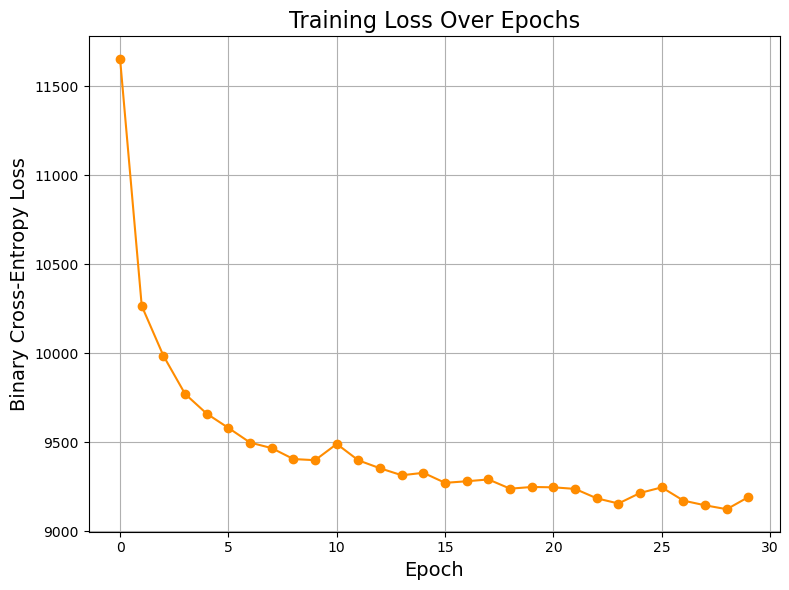

In [9]:
import matplotlib.pyplot as plt
# ---------------------------------------
# 6. Visualize the loss curve
# ---------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(loss_vals, 'o-', color='darkorange')
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Binary Cross-Entropy Loss", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
def visualize_reconstructions(model, test_loader, num_images=8):
    """
    Visualize original and reconstructed images
    
    Args:
        model (nn.Module): Trained autoencoder model
        test_loader (DataLoader): Test data loader
        num_images (int): Number of images to visualize
    """
    model.eval()  # Set model to evaluation mode
    
    # Get a batch of test data
    with torch.no_grad():
        x, _ = next(iter(test_loader))
        x = x.to(device)
        
        # Get reconstructions
        reconstructed, _, _ = model(x)
        
        # Move data back to CPU for visualization
        x = x.cpu()
        reconstructed = reconstructed.cpu()
        
        # Create subplots
        fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(x[i].squeeze())
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstructed images
            reconstructed_img = reconstructed[i].view(28, 28)
            axes[1, i].imshow(reconstructed_img)
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
visualize_reconstructions(model=model, test_loader=test_loader)

NameError: name 'plt' is not defined

In [6]:
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader

def encode_batch_vae(model, dataset_to_encode, batch_size=128, use_gpu=False):
    """
    Encode a dataset using a Variational Autoencoder (VAE). Only uses the mean (mu) as representation.

    Args:
        model: Trained VAE model (must have an `encode()` method returning mu and logvar)
        dataset_to_encode: PyTorch Dataset object to encode
        batch_size (int): Batch size for processing
        use_gpu (bool): If True, moves model and data to GPU

    Returns:
        tuple: (latent_codes, labels) where:
            - latent_codes: numpy array of shape [N, latent_dim]
            - labels: numpy array of shape [N]
    """
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    latent_codes = []
    labels = []

    print(f"Encoding dataset with {len(dataset_to_encode)} samples...")

    data_loader = DataLoader(dataset_to_encode, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x = x.to(device)

            # Get mu from VAE (encode returns both mu and logvar)
            mu, _ = model.encoder(x)
            latent = mu.cpu().numpy()

            latent_codes.append(latent)
            labels.append(y.cpu().numpy())

            if batch_idx % 50 == 0:
                print(f"Processed batch {batch_idx}/{len(data_loader)}")

    # Combine batches
    latent_codes = np.vstack(latent_codes)
    labels = np.hstack(labels)

    print(f"Encoding complete! Latent shape: {latent_codes.shape}, Labels shape: {labels.shape}")

    return latent_codes, labels

In [7]:
latent_codes, labels = encode_batch_vae(model, test_dataset, batch_size=128)

Encoding dataset with 10000 samples...
Processed batch 0/79
Processed batch 50/79
Encoding complete! Latent shape: (10000, 2), Labels shape: (10000,)


(-20.0, 20.0)

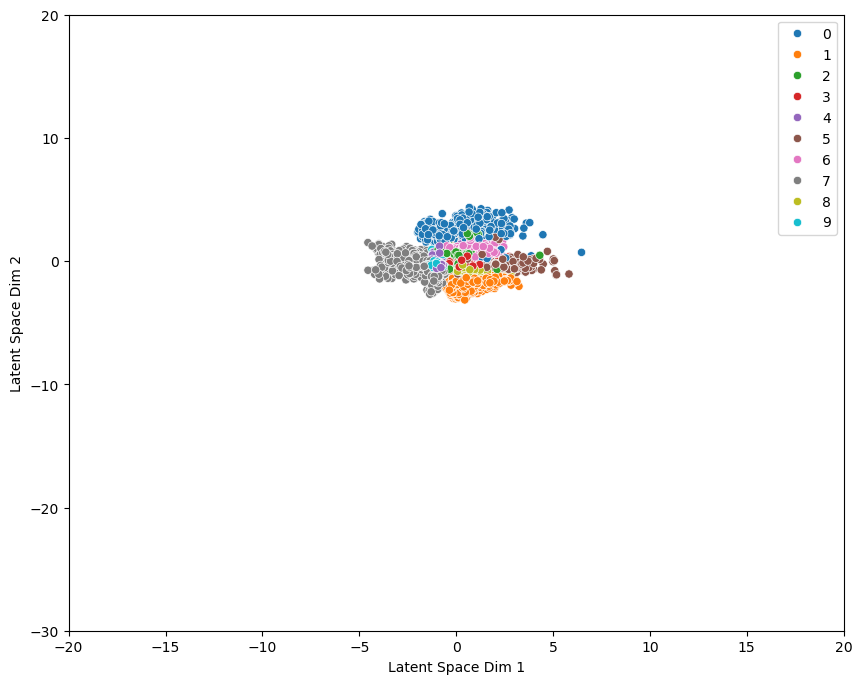

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.scatterplot(x=latent_codes[:,0], y=latent_codes[:,1], hue=[str(l) for l in labels], hue_order=[str(i) for i in range(10)], legend="full")
plt.xlabel("Latent Space Dim 1")
plt.ylabel("Latent Space Dim 2")
plt.ylim(-30, 20)
plt.xlim(-20, 20)

##  How to Generate Images with a VAE Decoder Using **Noise**

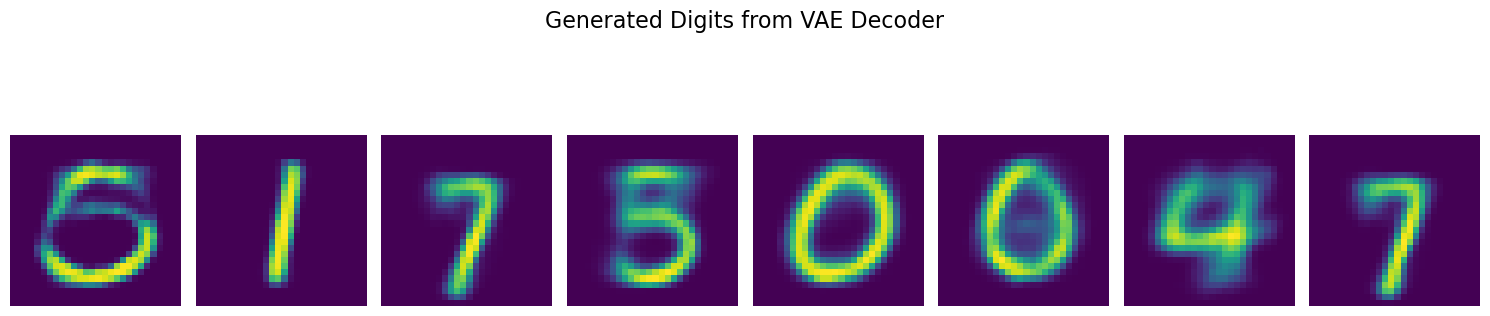

In [22]:
# 1. Sample latent vectors
n_samples = 8
latent_dim = 2

# Sample z ~ N(0, I)
z = torch.randn(n_samples, latent_dim)

# 2. Use the decoder
model.eval()
with torch.no_grad():
    generated = model.decoder(z.cpu())  # shape: [n_samples, 784]
    images = generated.view(-1, 1, 28, 28).cpu()  # reshape for plotting

# ----- Plot -----
fig, axs = plt.subplots(1, n_samples, figsize=(15, 4))
for i in range(n_samples):
    axs[i].imshow(images[i].squeeze())
    axs[i].axis('off')

plt.suptitle("Generated Digits from VAE Decoder", fontsize=16)
plt.tight_layout()
plt.show()  

## Conditional Variational Autoencoder (CVAE)

A **Conditional Variational Autoencoder (CVAE)** is an extension of the Variational Autoencoder (VAE) that allows the model to generate data **conditioned on auxiliary information**, such as class labels or physical parameters.


In a **CVAE**, we instead model:
- $q(z|x, y)$: the encoder conditions on both the input and label
- $p(x|z, y)$: the decoder reconstructs the input conditioned on both the latent code and label

This means that the model can **learn to generate or reconstruct data corresponding to specific classes, labels, or physics parameters**.

##  Why is CVAE Useful?

The conditioning variable $ y $ allows the model to:
- Generate specific types of data (e.g. digits, particle events, neutrino types)
- Separate semantic content (what to generate) from variation (how it looks)
- Learn disentangled latent representations
- Control the generation process with interpretable inputs

##  Applications in Particle and Astroparticle Physics

### 1. **Simulated Event Generation**
- CVAEs can be trained on Monte Carlo simulations (e.g., Geant4, CORSIKA).
- The conditioning variable can be particle type, energy, zenith angle, etc.
- Once trained, the CVAE can generate realistic detector hits or waveforms given specific physical parameters.

### 2. **Fast Detector Simulation / Emulation**
- Replace slow detector simulations with fast CVAE-based surrogates.
- Useful in collider experiments (ATLAS/CMS) and neutrino observatories (IceCube, KM3NeT).
- Conditioning on kinematic variables (momentum, vertex) enables fast inference pipelines.

### 3. **Conditional Denoising / Reconstruction**
- In low-SNR environments (e.g., neutrino detection, gravitational waves), CVAEs can be used to **reconstruct signal-like events** conditioned on prior physics knowledge.

### 4. **Anomaly Detection with Class Conditioning**
- Conditioning on known particle classes, a CVAE can help detect **anomalous events** that do not match the expected distribution.
- Useful in searches for BSM (Beyond Standard Model) physics or rare signatures.

## 📌 Summary

| Model        | Conditioning? | Generative | Label-aware | Applications            |
|--------------|---------------|------------|-------------|--------------------------|
| VAE          | ❌ No          | ✅ Yes     | ❌ No        | Unsupervised generation  |
| **CVAE**     | ✅ Yes         | ✅ Yes     | ✅ Yes       | Controlled generation, physics emulation, inference |

CVAE provides a flexible and powerful framework to **bridge data-driven models with physics-based conditioning**, enabling fast, interpretable, and controllable generation of scientific data.


In [23]:
def one_hot(labels, num_classes=10):
    """
    Convert integer class labels to one-hot encoded vectors.

    Args:
        labels (Tensor): LongTensor of shape [B]
        num_classes (int): Total number of classes (e.g., 10 for MNIST)

    Returns:
        Tensor of shape [B, num_classes]
    """
    return torch.nn.functional.one_hot(labels, num_classes).float()

def reparameterize(mu, logvar):
    """
    Sample from N(mu, sigma^2) using the reparameterization trick.

    Args:
        mu (Tensor): Mean of shape [B, latent_dim]
        logvar (Tensor): Log variance of shape [B, latent_dim]

    Returns:
        Sampled z from q(z|x,y), shape [B, latent_dim]
    """
    std = torch.exp(0.5 * logvar)           # Convert log variance to std
    eps = torch.randn_like(std)             # Sample from standard normal
    return mu + eps * std                   # z = mu + sigma * epsilon

class CVAEEncoder(nn.Module):
    def __init__(self, input_dim=784, label_dim=10, hidden_dim=128, latent_dim=2):
        super().__init__()
        # First layer: image + label → hidden
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        # Second layer: hidden → smaller hidden
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        # Outputs for latent distribution
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

    def forward(self, x, y_onehot):
        x = x.view(x.size(0), -1)                # Flatten images to [B, 784]
        x = torch.cat([x, y_onehot], dim=1)      # Concatenate class label [B, 784+10]
        h = torch.relu(self.fc1(x))              # First hidden layer
        h = torch.relu(self.fc2(h))              # Second hidden layer
        mu = self.fc_mu(h)                       # Mean of q(z|x,y)
        logvar = self.fc_logvar(h)               # Log-variance of q(z|x,y)
        return mu, logvar

class CVAEDecoder(nn.Module):
    def __init__(self, latent_dim=2, label_dim=10, hidden_dim=128, output_dim=784):
        super().__init__()
        # First layer: latent + label → hidden
        self.fc1 = nn.Linear(latent_dim + label_dim, hidden_dim // 2)
        # Second layer: hidden → expanded
        self.fc2 = nn.Linear(hidden_dim // 2, hidden_dim)
        # Final layer: hidden → reconstructed image
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y_onehot):
        z = torch.cat([z, y_onehot], dim=1)      # Concatenate latent and label
        h = torch.relu(self.fc1(z))              # Hidden layer
        h = torch.relu(self.fc2(h))              # Expanded hidden
        x_hat = torch.sigmoid(self.fc3(h))       # Output [B, 784], scaled to [0, 1]
        return x_hat

class CVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=2, label_dim=10):
        super().__init__()
        self.encoder = CVAEEncoder(input_dim, label_dim, hidden_dim, latent_dim)
        self.decoder = CVAEDecoder(latent_dim, label_dim, hidden_dim, input_dim)

    def forward(self, x, y):
        """
        Forward pass through the CVAE.

        Args:
            x (Tensor): input images [B, 784]
            y (Tensor): class labels [B]

        Returns:
            Tuple of (reconstructed x, mu, logvar)
        """
        y_onehot = one_hot(y)                           # One-hot encode labels
        mu, logvar = self.encoder(x, y_onehot)          # Get latent distribution
        z = reparameterize(mu, logvar)                  # Sample latent z
        x_hat = self.decoder(z, y_onehot)               # Decode with label conditioning
        return x_hat, mu, logvar

    def generate(self, y, z=None):
        """
        Generate images from labels y and latent samples z.

        Args:
            y (Tensor): class labels [B]
            z (Tensor or None): sampled latents [B, latent_dim]

        Returns:
            Generated images [B, 784]
        """
        if z is None:
            z = torch.randn(len(y), self.encoder.fc_mu.out_features)
        y_onehot = one_hot(y)
        return self.decoder(z.to(y.device), y_onehot.to(y.device))

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------------------------------
# 1. Choose device
# -----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------------------------------
# 2. Define CVAE model
# -----------------------------------------------------
model = CVAE(input_dim=784, hidden_dim=128, latent_dim=2, label_dim=10).to(device)

# -----------------------------------------------------
# 3. Define CVAE loss and optimizer
# -----------------------------------------------------
def cvae_loss_function(recon_x, x, mu, logvar):
    """
    Compute total CVAE loss = reconstruction loss + KL divergence
    """
    x = x.view(-1, 784)  # Flatten input to match recon shape
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

optimizer = optim.Adam(model.parameters(), lr=0.002)

# -----------------------------------------------------
# 4. Training loop
# -----------------------------------------------------
epochs = 30
loss_vals = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x = x.to(device)       # Images
        y = y.to(device)       # Digit labels

        # Forward pass: input and label
        recon_x, mu, logvar = model(x, y)

        # Compute CVAE loss
        loss = cvae_loss_function(recon_x, x, mu, logvar)

        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    loss_vals.append(avg_loss)

    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f}")

Using device: cuda
Epoch  1 | Loss: 164.7589
Epoch  2 | Loss: 140.4888
Epoch  3 | Loss: 137.1780
Epoch  4 | Loss: 135.4154
Epoch  5 | Loss: 134.2338
Epoch  6 | Loss: 133.5180
Epoch  7 | Loss: 132.9363
Epoch  8 | Loss: 132.4767
Epoch  9 | Loss: 132.0835
Epoch 10 | Loss: 131.8318
Epoch 11 | Loss: 131.5787
Epoch 12 | Loss: 131.3686
Epoch 13 | Loss: 131.1590
Epoch 14 | Loss: 130.9935
Epoch 15 | Loss: 130.7875
Epoch 16 | Loss: 130.6932
Epoch 17 | Loss: 130.5474
Epoch 18 | Loss: 130.4326
Epoch 19 | Loss: 130.3318
Epoch 20 | Loss: 130.2205
Epoch 21 | Loss: 130.0973
Epoch 22 | Loss: 129.9750
Epoch 23 | Loss: 129.9018
Epoch 24 | Loss: 129.8414
Epoch 25 | Loss: 129.7916
Epoch 26 | Loss: 129.7077
Epoch 27 | Loss: 129.6775
Epoch 28 | Loss: 129.5291
Epoch 29 | Loss: 129.5348
Epoch 30 | Loss: 129.3831


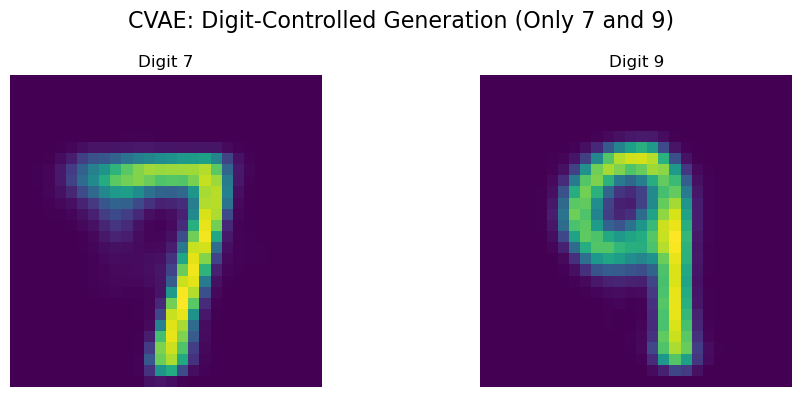

In [30]:
import torch
import matplotlib.pyplot as plt

model.eval()  # Set model to eval mode

# Choose only digits 7 and 9
digit_labels = torch.tensor([7, 9])  # Add more numbers as you want

with torch.no_grad():
    z = torch.randn(len(digit_labels), 2).to(device)             # Sample latent vectors
    generated = model.generate(digit_labels.to(device), z=z).cpu()  # Generate conditioned on labels
    images = generated.view(-1, 1, 28, 28)                        # Reshape to image format

# Plotting
fig, axs = plt.subplots(1, len(digit_labels), figsize=(10, 4))
for i in range(len(digit_labels)):
    axs[i].imshow(images[i].squeeze())
    axs[i].set_title(f"Digit {digit_labels[i].item()}")
    axs[i].axis('off')

plt.suptitle("CVAE: Digit-Controlled Generation (Only 7 and 9)", fontsize=16)
plt.tight_layout()
plt.show()


## Datasets Beyond Digits: Galaxies, Particles, and Physics

While MNIST is a great starting point, there are domain-specific datasets for more advanced applications of **VAEs** — especially in astronomy and particle physics.

### Galaxy Datasets for VAEs

A great resource for learning and practicing VAEs in an astrophysical context is the **Galaxy Datasets** repository:

**GitHub**: [mwalmsley/galaxy-datasets](https://github.com/mwalmsley/galaxy-datasets)

These datasets include:
- Galaxy types
- Real telescope images
- Synthetic galaxy simulations
- Preprocessed datasets suitable for training generative models (e.g., VAE, GAN)

They are ideal for experimenting with:
- Classification
- Image reconstruction
- Generative modeling of astrophysical objects
- Latent space interpolation between galaxy types


### VAE Applications in Particle & Astroparticle Physics

VAEs are increasingly being applied in **scientific domains** where data is high-dimensional, noisy, and physically structured. Some prominent use cases include:

#### 1. **Anomaly Detection in Particle Detectors**
- Identify rare or unexpected events (e.g., in CMS, IceCube, JUNO)
- Compare reconstructed vs. observed waveforms or calorimeter patterns

#### 2. **Latent Representation of Event Topologies**
- Learn compressed representations of complex detector signatures
- Enable clustering or conditional generation of neutrino or cosmic ray events

#### 3. **Simulation Surrogates**
- Use VAEs as fast simulators to mimic expensive Monte Carlo chains
- Learn a generative model conditioned on physical parameters (CVAE)

#### 4. **Astrophysical Image Generation**
- Model galaxies, supernova remnants, or sky surveys with generative VAEs
- Use learned latent space to explore physical parameter effects (e.g., redshift, shape, brightness)